

```
Depedences :

*   pandas : Library untuk memanipulasi dan melakukan analisis data tabular.
*   numpy : Library untuk melakukan operasi matematika dan array multidimensi
*   string : Library untuk memanipulasi data text
*   IPython.display : Library untuk menampilkan data grafik dan tabel di IPython Environments
*   sklearn : Library untuk menjalankan algoritma sistem rekomendasi
*   Warning : Library untuk menyaring warning program
*   zipfile : Library untuk mengekstrak atau membaca konten file Zip
*   tensorflow : Library untuk menjalan berbagai operasi matematika dan machine learning
*   pathlib : Library untuk melakukan manipulasi file atau direktori

```



In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import string

from IPython.display import display

from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

from google.colab import data_table
data_table.enable_dataframe_formatter()



```
Class RecommenderNet melakukan Inheritance dari model keras. RecommenderNet dibentuk dari
layer Embedding.Fungsi call bekerja dengan cara mengambil vektor user, vektor makanan, dan bias.
Data ini digunakan untuk menghitung perkalian dot antara vektor dan hasilnya ditambahkan dengan
bias user dan bias makanan. Hasil akhirnya akan mengembalikan sigmoid dari hasil penjumlahan sebelumnya.
```



In [29]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_food, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_food = num_food
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.food_embedding = layers.Embedding(
        num_food,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.food_bias = layers.Embedding(num_food, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    food_vector = self.food_embedding(inputs[:, 1])
    food_bias = self.food_bias(inputs[:, 1])

    dot_user_food = tf.tensordot(user_vector, food_vector, 2)

    x = dot_user_food + user_bias + food_bias

    return tf.nn.sigmoid(x)



```
Class yang berisikan fungsi - fungsi untuk menjalankan Recommendation System

Methods
-------
data_understanding(self)
    Menampilkan keseluruhan data.

EDA(self)
    Menampilkan informasi yang terdapat dalam data untuk dilakukan analisis dan pengecekan.

data_preprocessing(self)
    Menjalankan serangkaian operasi untuk menghilangkan data yang tidak diperlukan.

content_based_filtering(self)
    Melakukan ekstraksi fitur teks dan mengukur kemiripan antara dua vektor data.

get_food_recommendation(self,food_name,k=7)
    Mendapatkan rekomendasi dari makanan yang dimasukkan sebanyak 7 data rekomendasi.

show_data(self, data : dict, show_index = False)
    Menampilkan data yang dimasukkan.
  
show_data_info(self, data : dict, show_index = False)
    Menampilkan informasi data.

show_data_head(self, data : dict, show_index = False)
    Menampilkan 5 data pertama

show_data_describe(self, data : dict, show_index = False)
    Menampilkan deskripsi data.

check_isnull(self, data : dict)
    Cek jumlah null data.

check_isna(self, data : dict)
    Cek jumlah NaN data.            
```



In [30]:
class system_recommendation:
  def __init__(self, *args):

    self.food = pd.read_csv(args[0])
    self.rating = pd.read_csv(args[1])

  def data_understanding(self):
    self.show_data(self.food);
    self.show_data(self.rating)

  def EDA(self):
    for d in [self.food, self.rating]:
      print()
      self.show_data_info(d)
      self.show_data_head(d)
      self.show_data_describe(d)
      self.check_isnull(d)
      self.check_isna(d)
      print("==="*100)
      print("==="*100)
      print("==="*100)
      print()

  def data_preprocessing(self):
    self.food["Describe"] = self.food["Describe"].apply(lambda x : "".join([y for y in x if y not in string.punctuation]))

    self.food_rating = self.rating.copy()
    self.all_food = pd.merge(self.food_rating, self.food, on='Food_ID', how='left')
    self.show_data(self.all_food)

  def data_preparation(self):
    self.check_isnull(self.all_food)
    self.check_isna(self.all_food)

    print()
    print("Drop Nan Value")
    self.all_food.dropna(axis=0, inplace=True)

    self.check_isnull(self.all_food)
    self.check_isna(self.all_food)

    self.final_food = self.all_food.sort_values('Food_ID', ascending=True)
    self.final_food = self.final_food.drop_duplicates('Food_ID')

    self.final_food["Explanation"] = self.final_food.apply(lambda x : " ".join([x["C_Type"],
                                                                                x["Veg_Non"],
                                                                                x["Describe"]]), axis=1)

    self.show_data(self.final_food)

    self.food_id = self.final_food.Food_ID.tolist()
    self.food_name = self.final_food.Name.tolist()
    self.food_desc = self.final_food.Explanation.tolist()

    print()
    print("Ukuran Data ID : ", len(self.food_id))
    print("Ukuran Data Nama : ", len(self.food_name))
    print("Ukuran Data Description : ", len(self.food_desc))

    self.final_food_new = pd.DataFrame({
        "foodID": self.food_id,
        "foodName": self.food_name,
        "foodDesc": self.food_desc
    })

    self.show_data(self.final_food_new)

  def content_based_filtering(self):
    self.tfidf = TfidfVectorizer(stop_words='english')

    self.tfidf.fit(self.food['Describe'])
    self.tfidf_array = self.tfidf.get_feature_names_out()
    print("Jumlah Data : ", len(self.tfidf_array))

    self.tfidf_matrix = self.tfidf.fit_transform(self.final_food_new['foodDesc'])
    print("Ukuran Matrix tfidf : ", self.tfidf_matrix.shape)

    self.tfidf_matrix.todense()

    self.df_tfidf = pd.DataFrame(self.tfidf_matrix.todense(),
                                 columns=self.tfidf.get_feature_names_out(),
                                 index=self.final_food_new.foodName
                                 ).sample(22, axis=1).sample(10, axis=0)
    self.show_data(self.df_tfidf, True)

    print()
    print("Cosine Similarity")
    print()
    self.cos_sim = cosine_similarity(self.tfidf_matrix)
    print(self.cos_sim)

    self.cs_df = pd.DataFrame(self.cos_sim, index=self.final_food_new['foodName'], columns=self.final_food_new['foodName'])
    print('Shape:', self.cs_df.shape)

    self.show_data(self.cs_df.sample(5, axis=1).sample(10, axis=0), True)

  def get_content_based_filtering_recommendation(self,
                              food_name,
                              k=7, show = True):

    self.similarity = self.cs_df
    self.items = self.final_food_new[['foodName', 'foodDesc']]

    self.index = self.similarity.loc[:,food_name].to_numpy().argpartition(
        range(-1, -k, -1))

    self.closest = self.similarity.columns[self.index[-1:-(k+2):-1]]

    self.closest = self.closest.drop(food_name, errors='ignore')

    self.cbf_result = pd.DataFrame(self.closest).merge(self.items).head(k)

    if show:
      self.show_data(self.cbf_result, True)
    return self.cbf_result

  def evaluation(self):

    self.vectorizer = TfidfVectorizer()
    self.eval_final_food = self.final_food_new.copy().foodName.values
    self.scores = []

    for food_name in self.eval_final_food:
      self.eval_cbf_result = self.get_content_based_filtering_recommendation(food_name = food_name, show = False)

      self.food_index = self.final_food_new['foodName'].index[self.final_food_new['foodName'] == food_name][0]
      self.food_desc = self.final_food_new.loc[self.food_index].foodDesc

      self.cbf_food = self.eval_cbf_result.foodDesc
      for i, x in enumerate(self.cbf_food):
        self.vectorized_text = self.vectorizer.fit_transform([x, self.food_desc])
        self.cosine_sim = cosine_similarity(self.vectorized_text)
        self.similarity_score = self.cosine_sim[0, 1]
        self.scores.append([1 if self.similarity_score > 0.25 else 0][0])
        # self.eval_cbf_result.loc[i, 'similarityScore'] = [1 if self.similarity_score > 0.25 else 0][0]

      # self.show_data(self.eval_cbf_result, True)
      # self.eval_desc = self.eval_cbf_result.similarityScore.values
      # self.scores = np.append(self.scores, self.eval_desc)
      # print(self.scores)

    print("Performa Content-Based Filtering : ", np.mean(self.scores))

  def collaborative_filtering(self):
    self.rating_data = self.final_food.copy()
    self.rating_data = self.rating_data[["User_ID", "Food_ID", "Rating"]]

    # print()
    # self.show_data(self.rating_data)
    # self.check_isna(self.rating_data)
    # self.check_isnull(self.rating_data)

    # self.num_user_rating = self.rating_data.groupby(by = "User_ID").count()
    # self.num_food_rating = self.rating_data.groupby(by = "Food_ID").count()

    # self.num_user_rating = self.num_user_rating['Rating'].reset_index().rename(columns = {'Rating':'Num_User_Rating'})
    # self.num_food_rating = self.num_food_rating["Rating"].reset_index().rename(columns = {'Rating':'Num_Food_Rating'})

    # self.show_data(self.num_user_rating)
    # self.show_data(self.num_food_rating)

    # self.rating_matrix = self.rating_data.pivot_table(index='Food_ID',columns='User_ID',values='Rating').fillna(0)
    # self.show_data_head(self.rating_matrix, True)
    # print(self.rating_matrix.shape)

    # self.csr_rating = csr_matrix(self.rating_matrix.values)
    # print(self.csr_rating)

    # self.rating_KNN = NearestNeighbors(metric = "cosine")
    # self.rating_KNN.fit(self.csr_rating)

    self.show_data(self.rating_data)

    self.user_data = self.rating_data.User_ID.unique().tolist()
    self.user_to_encoded = {x: y for y, x in enumerate(self.user_data)}
    self.encoded_to_user = {y: x for y, x in enumerate(self.user_data)}

    self.food_data = self.rating_data.Food_ID.unique().tolist()
    self.food_to_encoded = {x: y for y, x in enumerate(self.food_data)}
    self.encoded_to_food = {y: x for y, x in enumerate(self.food_data)}

    self.rating_data['user'] = self.rating_data['User_ID'].map(self.user_to_encoded)
    self.rating_data['food'] = self.rating_data['Food_ID'].map(self.food_to_encoded)

    self.rating_data['Rating'] = self.rating_data['Rating'].values.astype(np.float32)

    print(f"""
Jumlah Pengguna : {len(self.user_to_encoded)}
Jumlah Makanan  : {len(self.food_to_encoded)}
Minimal Rating  : {min(self.rating_data["Rating"])}
Maximal Rating  : {max(self.rating_data["Rating"])}
    """)

    self.rating_data = self.rating_data.sample(frac=1, random_state=1605)
    self.show_data(self.rating_data)

    self.x_data = self.rating_data[["user", "food"]].values
    self.y_data = self.rating_data["Rating"].apply(lambda x: (x-min(self.rating_data["Rating"]))/(max(self.rating_data["Rating"]) - min(self.rating_data["Rating"])))
    self.scale_index = int(0.75*self.rating_data.shape[0])

    self.x_train, self.x_val, self.y_train, self.y_val = (
      self.x_data[:self.scale_index],
      self.x_data[self.scale_index:],
      self.y_data[:self.scale_index],
      self.y_data[self.scale_index:]
    )

  def train(self):

    self.model_NN = RecommenderNet(num_users = len(self.user_to_encoded),
                                   num_food = len(self.food_to_encoded),
                                   embedding_size = 42)

    self.model_NN.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = keras.optimizers.Adam(learning_rate=3e-3),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    history = self.model_NN.fit(
      x = self.x_train,
      y = self.y_train,
      batch_size = 7,
      epochs = 50,
      validation_data = (self.x_val, self.y_val)
    )

    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('Model Metrics')
    plt.ylabel('RMSE')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

  def get_collaborative_filtering_recommendation(self, k = 7):



    # self.cf_food = self.final_food_new.copy()

    # self.cf_food_name = self.cf_food[self.cf_food["foodName"] == food_name]
    # self.cf_food_index = np.where(self.rating_matrix.index==int(self.cf_food_name['foodID']))[0][0]
    # self.cf_food_rating = self.rating_matrix.iloc[self.cf_food_index]

    # self.cf_reshape = self.cf_food_rating.values.reshape(1, -1)
    # self.cf_distance, self.cf_indices = self.rating_KNN.kneighbors(self.cf_reshape,
    #                                                                n_neighbors = 10)

    # self.cf_KNN_indices = self.rating_matrix.iloc[self.cf_indices[0]].index[1:]
    # self.cf_KNN = pd.DataFrame({"foodID" : self.cf_KNN_indices})

    # self.show_data(pd.merge(self.cf_KNN,
    #                        self.cf_food,
    #                        on='foodID',
    #                        how='left').drop("foodID", axis = 1).head(k), True)

    self.cf_rating_data = self.final_food.copy()[["User_ID",
                                            "Food_ID",
                                            "Rating",
                                            "Name",
                                            "Explanation"]]

    self.sample_data = self.cf_rating_data.User_ID.sample(1).iloc[0]

    self.food_ordered_by_user = self.cf_rating_data[self.cf_rating_data.User_ID == self.sample_data]

    self.food_df = self.final_food.copy()
    self.food_not_ordered_by_user = self.food_df[~self.food_df['User_ID'].isin(self.food_ordered_by_user.Food_ID.values)]['User_ID']
    self.food_not_ordered_by_user = list(
        set(self.food_not_ordered_by_user)
        .intersection(set(self.food_to_encoded.keys()))
    )

    self.food_not_ordered_by_user = [[self.food_to_encoded.get(x)] for x in self.food_not_ordered_by_user]
    self.user_encoder = self.user_to_encoded.get(self.sample_data)
    self.user_food_array = np.hstack(
        ([[self.user_encoder]] * len(self.food_not_ordered_by_user), self.food_not_ordered_by_user)
    )

    #Prediction
    self.rating_results = self.model_NN.predict(self.user_food_array).flatten()
    self.top_rating_idx = self.rating_results.argsort()[-10:][::-1]
    self.recommended_food_idx = [
        self.encoded_to_food.get(self.food_not_ordered_by_user[x][0]) for x in self.top_rating_idx
    ]

    print('Showing recommendations for users: {}'.format(self.sample_data))
    print('===' * 9)
    print('Food with high ratings from user')
    print('----' * 8)

    self.top_food_user = (
        self.food_ordered_by_user.sort_values(
            by = 'Rating',
            ascending=False
        )
        .head(5)
        .Food_ID.values
    )

    self.food_df_rows = self.cf_rating_data[self.cf_rating_data['User_ID'].isin(self.top_food_user)]

    self.top_food = {
        "foodName" : {x.Name for x in self.food_df_rows.itertuples()},
        "foodDesc" : {x.Explanation for x in self.food_df_rows.itertuples()}
    }
    self.top_food = {key: list(value) for key, value in self.top_food.items()}

    self.show_data(pd.DataFrame(self.top_food), True)

    self.recommended_food = self.cf_rating_data[self.cf_rating_data['User_ID'].isin(self.recommended_food_idx)]

    self.top_food = {
        "foodName" : {x.Name for x in self.recommended_food.itertuples()},
        "foodDesc" : {x.Explanation for x in self.recommended_food.itertuples()}
    }
    self.top_food = {key: list(value) for key, value in self.top_food.items()}
    self.recommended_food_df = pd.DataFrame(self.top_food).head(10)
    print('----' * 8)
    print(f'Top {len(self.recommended_food_df.foodName.values.tolist())} food recommendation')
    print('----' * 8)
    self.show_data(self.recommended_food_df, True)

  def show_data(self, data : dict, show_index = False):
    display(data_table.DataTable(data, include_index = show_index, num_rows_per_page=10))
    try:
      print("Jumlah Food ID Unik: ", len(data.Food_ID.unique()))
      try:
        print("Jumlah User ID Unik : ", len(data.User_ID.unique()))
        print("Jumlah Rating : ", len(data.Rating))
      except:
        pass
    except:
        pass

  def show_data_info(self, data : dict, show_index = False):
    return data.info()
    print()

  def show_data_head(self, data : dict, show_index = False):
    display(data_table.DataTable(data.head(), include_index = show_index, num_rows_per_page=10))
    return data.head()
    print()

  def show_data_describe(self, data : dict, show_index = False):
    display(data_table.DataTable(data.describe(), include_index = show_index, num_rows_per_page=10))
    return data.describe()
    print()

  def check_isnull(self, data : dict):
    print("Null Data Check")
    display(data.isnull().sum())
    print()

  def check_isna(self, data : dict):
    print("Nan Data Check")
    display(data.isna().sum())
    print()

sr = system_recommendation("https://gitlab.com/yunus.bayu.aji/house-price-dataset/-/raw/main/system%20recommendation/food.csv",
                          "https://gitlab.com/yunus.bayu.aji/house-price-dataset/-/raw/main/system%20recommendation/ratings.csv")



```
Data understanding menampilkan dua buah data yaitu food data dan rating data. Food data mempunyai 400 id makanan unik dan mempunyai 512 total rating.

Data food mempunyai beberapa variabel terkait seperti :

- Food_ID : ID makanan
- Name    : Nama makanan
- C_Type  : Jenis makanan
- Veg_Non : Vegetarian atau tidak
- Describe: Deskripsi makanan

sedangkan pada data rating hanya terdapat User_ID, Food_ID, dan Rating
```



In [31]:
sr.data_understanding()

Jumlah Food ID Unik:  400


Jumlah Food ID Unik:  310
Jumlah User ID Unik :  101
Jumlah Rating :  512




```
Dalam Exploratory Data Analysis (EDA), operasi yang dijalankan adalah
menampilkan informasi mengenai data yang akan digunakan seperti informasi data,
deskripsi data, dan pengecekan apakah terdapat missing data atau tidak.
```



In [32]:
sr.EDA()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB


Null Data Check


Food_ID     0
Name        0
C_Type      0
Veg_Non     0
Describe    0
dtype: int64


Nan Data Check


Food_ID     0
Name        0
C_Type      0
Veg_Non     0
Describe    0
dtype: int64




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB


Null Data Check


User_ID    1
Food_ID    1
Rating     1
dtype: int64


Nan Data Check


User_ID    1
Food_ID    1
Rating     1
dtype: int64



```
Preprocessing data dilakukan dalam dua tahap yaitu

1. Menghilangkan tanda baca yang terdapat dalam deskripsi.

2. Menggabungkan data food dan rating menjadi satu berdasarkan Food_ID data food.
```



In [33]:
sr.data_preprocessing()

Jumlah Food ID Unik:  310
Jumlah User ID Unik :  101
Jumlah Rating :  512




```
Preparasi data akan melakukan pengecekan terhadap data, penggabungan data, dan membuat dataset.

1. Tahap pertama adalah melakukan pengecekan data, apakah masih terdapat data
null dan nan setelah di lakukan penggabungan data sebelumnya. Dalam hal ini
ternyata masih terdapat 1 data, untuk itu dilakukan drop pada data tersebut.

2. Tahap kedua adalah melakukan penggabungan data, data yang digabung adalah
data jenis makanan, vegetarian atau tidak, dan deskripsi data, penggabungan
dilakukan dengan join ke dalam 1 sub data yaitu "Explanation".

3. Membentuk dataset yang digunakan untuk sistem rekomendasi, data yang
digunakan adalah ID makanan, nama makanan, dan deskripsi/explanasi makanan.
```



In [34]:
sr.data_preparation()

Null Data Check


User_ID     1
Food_ID     1
Rating      1
Name        1
C_Type      1
Veg_Non     1
Describe    1
dtype: int64


Nan Data Check


User_ID     1
Food_ID     1
Rating      1
Name        1
C_Type      1
Veg_Non     1
Describe    1
dtype: int64



Drop Nan Value
Null Data Check


User_ID     0
Food_ID     0
Rating      0
Name        0
C_Type      0
Veg_Non     0
Describe    0
dtype: int64


Nan Data Check


User_ID     0
Food_ID     0
Rating      0
Name        0
C_Type      0
Veg_Non     0
Describe    0
dtype: int64

Jumlah Food ID Unik:  309
Jumlah User ID Unik :  97
Jumlah Rating :  309

Ukuran Data ID :  309
Ukuran Data Nama :  309
Ukuran Data Description :  309




```
Content Based Filtering (CBF) akan menjalankan ekstraksi fitur
teks pada "Deskripsi" data, kemudian membuat sebuah matrix yang
merepresentasikan kumpulan dokumen, data ini kemudian akan
dilakukan perhitungan kesamaan menggunakan metrik cosine similarity
```



In [35]:
sr.content_based_filtering()

Jumlah Data :  1261
Ukuran Matrix tfidf :  (309, 1115)



Cosine Similarity

[[1.00000000e+00 1.91094097e-01 1.17109349e-01 ... 4.25776286e-03
  1.76041717e-03 1.05711464e-03]
 [1.91094097e-01 1.00000000e+00 6.09232130e-02 ... 8.03051693e-02
  6.72913029e-02 9.88699616e-04]
 [1.17109349e-01 6.09232130e-02 1.00000000e+00 ... 4.40915994e-02
  7.53345588e-02 6.62307630e-02]
 ...
 [4.25776286e-03 8.03051693e-02 4.40915994e-02 ... 1.00000000e+00
  3.16965957e-02 1.90335199e-02]
 [1.76041717e-03 6.72913029e-02 7.53345588e-02 ... 3.16965957e-02
  1.00000000e+00 6.89691129e-02]
 [1.05711464e-03 9.88699616e-04 6.62307630e-02 ... 1.90335199e-02
  6.89691129e-02 1.00000000e+00]]
Shape: (309, 309)




```
Fungsi collaborative filtering menggunakan rating sebagai data acuan.
Data rating dilakukan encoding, kemudian melakukan pembagian data dengan
perbandingan 3:1 antara data train dan validation
```



In [36]:
sr.collaborative_filtering()

Jumlah Food ID Unik:  309
Jumlah User ID Unik :  97
Jumlah Rating :  309

Jumlah Pengguna : 97
Jumlah Makanan  : 309
Minimal Rating  : 1.0
Maximal Rating  : 10.0
    


Jumlah Food ID Unik:  309
Jumlah User ID Unik :  97
Jumlah Rating :  309




```
Fungsi train digunakan untuk melakukan train data. train data dilakukan menggunakan class
RecommenderNet yang telah di definisikan sebelumnya. Train dilakukan dengan loss
Binary Crossentropy, optimizer Adam, dan metrics Root Mean Squared Error (RMSE).
```



Epoch 1/50
33/33 [==============================] - 1s 10ms/step - loss: 0.6984 - root_mean_squared_error: 0.3274 - val_loss: 0.6948 - val_root_mean_squared_error: 0.3242
Epoch 2/50
33/33 [==============================] - 0s 3ms/step - loss: 0.6878 - root_mean_squared_error: 0.3194 - val_loss: 0.6939 - val_root_mean_squared_error: 0.3235
Epoch 3/50
33/33 [==============================] - 0s 3ms/step - loss: 0.6842 - root_mean_squared_error: 0.3165 - val_loss: 0.6936 - val_root_mean_squared_error: 0.3233
Epoch 4/50
33/33 [==============================] - 0s 3ms/step - loss: 0.6521 - root_mean_squared_error: 0.2913 - val_loss: 0.6947 - val_root_mean_squared_error: 0.3242
Epoch 5/50
33/33 [==============================] - 0s 3ms/step - loss: 0.6627 - root_mean_squared_error: 0.2996 - val_loss: 0.6950 - val_root_mean_squared_error: 0.3244
Epoch 6/50
33/33 [==============================] - 0s 3ms/step - loss: 0.6662 - root_mean_squared_error: 0.3024 - val_loss: 0.6954 - val_root_mean_s

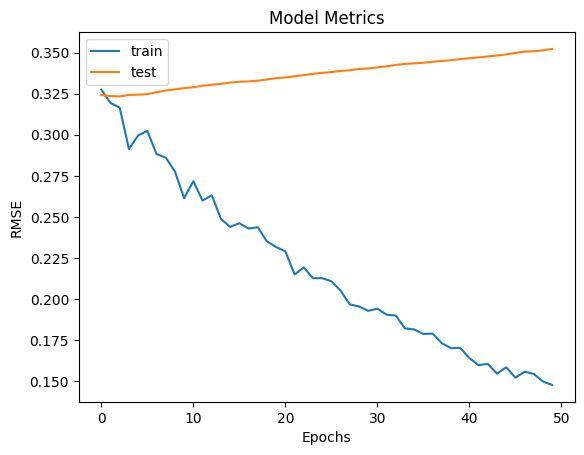

In [37]:
sr.train()



```
Menghitung performa Content-Based Filtering
```



In [38]:
sr.evaluation()

Performa Content-Based Filtering :  0.5681923254738789




```
Fungsi ini akan mengembalikan sebuah rekomendasi makanan berdasarkan kesamaan makanan yang diberikan pengguna.

Matriks akan menginisialisasi atribut similarity dan items,
kemudian mencari indeks k terdekat dalam matrix similarity untuk
makanan yang dimasukkan pengguna. kolom dengan indeks terdekat
akan diambil dan makanan yang sama akan dihapus dari daftar
rekomendasi. Hasilnya akan mengemablikan rekomendasi makanan
dengan k baris teratas
```



In [39]:
print("Result From Content Based Filtering")
food = "steamed chicken roulade"
sr.get_content_based_filtering_recommendation(food, show = False)

Result From Content Based Filtering


foodName  \
0            methi chicken masala   
1  restaurant style fried chicken   
2           cheese chicken kebabs   
3                   fish andlouse   
4                      lamb korma   
5        amritsari chicken masala   
6               bihari fish curry   

                                            foodDesc  
0  Indian non-veg boneless chicken lemon juice re...  
1  Chinese non-veg egg salt white pepper maida sa...  
2  Indian non-veg Chicken Thais Garlic Paste Garl...  
3  French non-veg white wine and water mix to cov...  
4  Indian non-veg onions almond paste ghee cinnam...  
5  Indian non-veg chicken ginger garlic paste cur...  
6  Indian non-veg rohu fish salt turmeric powder ...



```
Fungsi rekomendasi akan memberikan kembalian berupa 10 data makanan yang direkomendasikan.
Hasil dari training data digunakan untuk memprediksi data user id acak dan juga
menampilkan makanan dengan rating tinggi kepada user
```



In [41]:
print("Result From Collaborative Filtering")
sr.get_collaborative_filtering_recommendation()

Result From Collaborative Filtering
3/3 [==============================] - 0s 3ms/step
Showing recommendations for users: 32.0
Food with high ratings from user
--------------------------------


--------------------------------
Top 10 food recommendation
--------------------------------
